In [1]:
pwd

'/home/jose/Desktop/GitHub/Bidimensional_DMA_APS_inversion/Examples'

# Inversion of APS-DMA charge measurements

In [2]:
from linker import *
%matplotlib notebook

In [3]:
particle_density_gcm3 = 1.98

## Charge distributions

In [4]:
measurements_data =  pd.read_csv("/home/jose/Desktop/GitHub/Bidimensional_DMA_APS_inversion/Examples/data/measurements_data.dat")
measurements_data.head()

,ESP_V (kV),Voltage,Da,Dp,R
0,11.0,250,0.448956,0.319059,0.0
1,11.0,250,11.959399,8.499175,0.0
2,11.0,250,11.987193,8.518927,0.0
3,11.0,250,12.015010,8.538696,0.0
4,11.0,250,12.042850,8.558481,0.0


In [5]:
measurements_data_avg = measurements_data.groupby(by=["ESP_V (kV)","Voltage","Dp"]).agg((np.mean))
measurements_data_avg.reset_index(inplace = True)
measurements_data_avg.head()

,ESP_V (kV),Voltage,Dp,Da,R
0,11.0,250,0.319059,0.448956,0.0
1,11.0,250,0.330191,0.464621,0.0
2,11.0,250,0.341340,0.480308,0.0
3,11.0,250,0.352505,0.496018,0.0
4,11.0,250,0.363686,0.511751,0.0


<IPython.core.display.Javascript object>


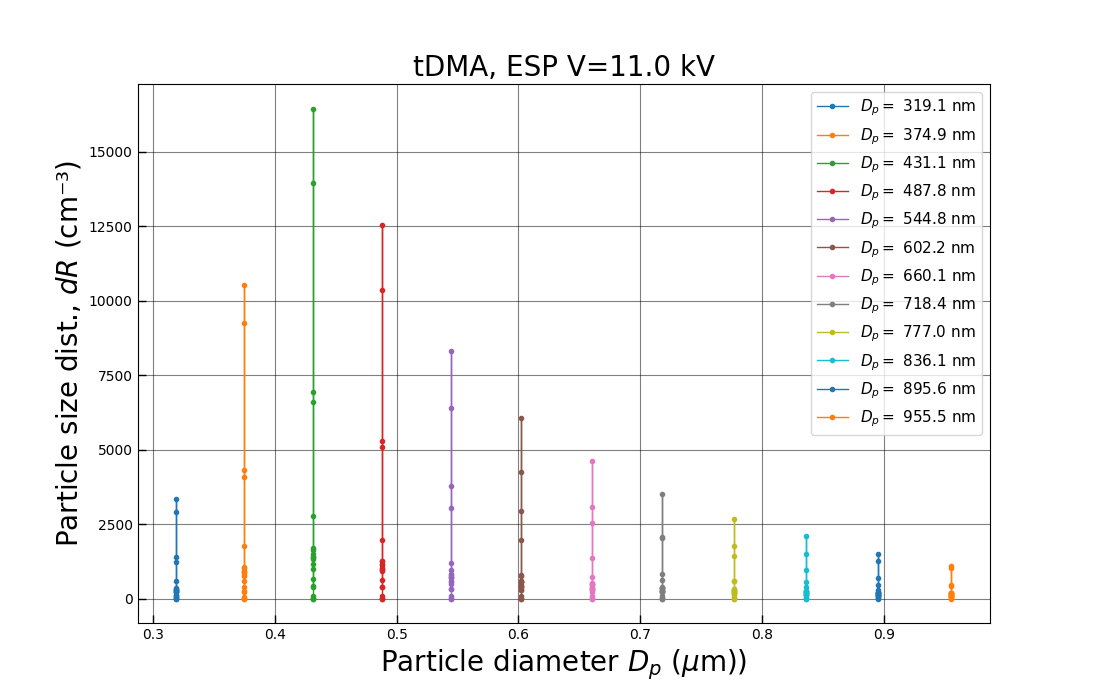

In [6]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'].values.copy())
Dps = np.unique(measurements_data_avg['Dp'].values.copy())

measurements_data_avg["V1"] = measurements_data_avg["Voltage"]
measurements_data_avg["Dp2"] = measurements_data_avg["Dp"].copy() * 1000 # to nanometers

for espV in ESPV:
    DMA_APS_support.Plot_ESPV(espV,
                              Dps,
                              measurements_data_avg,
                              line=True,
                              row='Dp',
                              column="R",
                              spline=False,
                              D_legend=True,
                              LogYscale=False,
                              export=False,
                              skip=5,
                              Dmax=1,
                              sort_col="Dp",
                              prefix="APS_Raw_")

## Deconvolution

Charge distribution measurements with the nDMA-APS configuration are made by stepping the nDMA voltage (again with 40 seconds between voltages) and making APS measurements (across aerodynamic size bins) for each voltage.  Measurements lead to APS number concentrations in each size bin $\mathrm{R(V,D_p)}$:

$$
    R(V,D_p) = \sum_z \Omega(V,Z_p)T(D_p)f(z)\frac{\partial N}{\partial D_p}dD_p,
$$

where $\Omega(V,Z_p)$ is the nDMA transfer function representing the probability of particles with electrical mobility $Z_p$ to be collected at the aerosol exit of the nDMA when operated at the voltage $V$. $T(D_p)$ is the nDMA penetration efficiency for particles with diameter $D_p$, and $f(z)$ is the particle charge fraction at $z>0$ elementary charges. 

### 1. Penetration efficiency

Penetration efficiency through the DMA is computed based on the
parameterized results by [A Reineking and J Porstendörfer (1986)](https://www.tandfonline.com/doi/abs/10.1080/02786828608959112).

$$T_l = 0.82\exp(-11.5u)+0.1\exp(-70.0u)+0.03\exp(-180.0u)+0.02\exp(-340.0u)$$

where $u = \frac{D_{ab} l_{eff}}{q_{sa}}$, $l_{eff}$ is the parameterized
effective diffusion length, and $q_{sa}$ is the aerosol flow rate through the DMA,
and $D_{ab}$ is the particle diffusion coefficient.

##   2.  DMA Transfer function

The DMA transfer function is the probability that a particle of a given size
exits the classifier via the sample flow. The diffusive broadened DMA transfer
function is computed assuming blanced sheath and excess flows using the expression 
of [Stolzenburg and McMurry (2008)](https://www.tandfonline.com/doi/full/10.1080/02786820802157823).
$$ \Omega(\tilde{z},\beta,\sigma) = \frac{\sigma}{\sqrt{2}\beta}\left[\epsilon \left( \frac{\tilde{z}-(1+\beta)}{\sqrt{2}\sigma} \right) + \epsilon \left (\frac{\tilde{z}-(1-\beta)}{\sqrt{2}\sigma} \right) - 2\epsilon \left ( \frac{\tilde{z}-1}{\sqrt{2}\sigma}\right)  \right]$$
    
where $\tilde{z} = \frac{z}{z^s}$ is the dimensionless mobility, $z$ is the particle mobility $z^s$ is the centroid mobility selected by the DMA, $\epsilon = x \mathrm{erf}(x) +\left(\exp(-x^2)/\sqrt{\pi}\right)$, $\mathrm{erf}$ is the error function, and $\beta = Q_{a}/Q_{sh}$ where $Q_a$ and $Q_{sh}$ are the aerosol and sheath flows, respectively. The parameter $\sigma$ accounts for diffusional broading of the transfer function. Assuming plug flow, $\sigma$ can be computed using the following equations <br> <br>
$\gamma = \left(\frac{r_1}{r_2}\right)^2$ <br>
$I = \frac{1}{2}(1+γ)$ <br>
$\kappa = \frac{lr_2}{r_2^2-r_1^2}$ <br>
$G = \frac{4(1+\beta)^2}{(1-γ)} \left[I+\{2(1+\beta)\kappa\}^{-2} \right ] $<br>
$\sigma = \sqrt{\frac{2G\pi ld_{ab}}{q_{sh}}}$

### 3. Fredholm Matrix form of the inversion problem

The $(\partial N/\partial D_p)dD_p$ represents the number concentration of particles with a diameter between $D_p$ and $D_p+dD_p$, and $R(V,D_p)$ is the reading of the APS in number concentration at the $D_p$ size bin when the nDMA is at voltage $V$. the inversion equation can be discretized into $\theta_1$ charge bins determined by the number of measured voltages $V$ (linearly spaced between 250 up to 5000 V with a step of 250 V) and into $\theta_2$ size bins determined by the resolution of the APS. Unlike TDMA measurements, in this case, the size bins are known and therefore the problem only consists of solving a total of $\theta_2$ equations to obtain the corresponding charge distributions for each particle size. For each fixed diameter $D_p$, this can be written in a matrix form by considering $x_j(z_j|D_{p}) = f(z_j)[\partial N/\partial D_p]dD_p$, $b_i(V_i|D_p)= R(V_i,D_p)$, and $A_{i,j}^{(1)}(V_i,z_j|D_p)=\Omega(V_i,Z_{p,j})T_1(D_p)$ where $i\in[1,\theta_1]$ and $j\in[1,\theta_2]$. Therefore it yields the following matrix equation, $$\textbf{b} = \textbf{A}\textbf{x}+\mathbf{\varepsilon},$$ where $\mathbf{\varepsilon}$ is the experimental error, $\textbf{b}\in\mathbb{R}^{\theta_1}$, $\textbf{A}\in\mathbb{R}^{\theta_1}\times \mathbb{R}^{\theta_1}$, and $\textbf{x}\in\mathbb{R}^{\theta_1}$. Each matrix is defined as follows,

$$
\textbf{b} = \left(
\begin{array}{c}
b_1(V_1|D_p) \\
\vdots \\
b_{\theta_1}(V_{\theta_1}|D_p)
\end{array}
\right);\hspace{1cm} \textbf{x} = \left(
\begin{array}{c}
x_1(z_1| D_p) \\
\vdots \\
x_{\theta_1}(z_{\theta_1}| D_p)
\end{array}
\right)
$$

$$
\textbf{A} = \left(
\begin{array}{ccc}
A^{(1)}(V_1,z_1|D_p) & \cdots & A^{(1)}(V_1,z_{\theta_1}|D_p)\\
\vdots & \ddots & \vdots\\
A^{(1)}(V_{\theta_1},z_1|D_p) & \cdots & A^{(1)}(V_{\theta_1},z_{\theta_1}|D_p)
\end{array}
\right).
$$

The matrix inversion equation is an ill-posed Fredholm equation solved  using a Tikhonov regularization. Under this method, the matrix inversion equation can be solved as (see equation 1.15 from [Vogel 2002](https://epubs.siam.org/doi/book/10.1137/1.9780898717570)),

$$
   \widetilde{\mathbf{x}} = (\mathbf{A}^t\mathbf{A}+\alpha \mathbf{I})^{-1}\mathbf{A}^t\mathbf{b}
$$

where the exponent $t$ refers to the transpose matrix, $\textbf{I}$ is the identity matrix (with dimensions $\zeta\times\zeta$) and $\alpha \in [0,\infty]$ is the regularization parameter. When $\alpha\rightarrow 0$ then the filtering of noise is insufficient and the result will be very oscillatory. On the other hand, when $\alpha\rightarrow\infty$ the noise is considerably reduced at the cost of overly smoothing the inverted curve. Therefore an optimum $\alpha$ is here selected by comparison between the original data and the convolution of the deconvoluted data.

## Setup DMA-1 & DMA-2

Include the properties of the DMA used including:

- model: The type of DMA. Two options are available "nano" and "long". Internally, the code will select the DMA length, internal, and external radii needed for the DMA transfer function calculation.
- flow_aerosol: Aerosol flow in L/min.
- flow_sheath: Sheath flow in L/min.
- Voltage: The DMA current voltage. Add a value to initialize the calculation of properties. This value is updated when needed and will update all the DMA properties depending on it.
- L_eff: Value used for determining the DMA penetration efficiency [A Reineking and J Porstendörfer (1986)](https://www.tandfonline.com/doi/abs/10.1080/02786828608959112).
- Pressure and Temperature: Aerosol properties in Pa and K, respectively.
- Charge_limit: This variable is only used when the charge distribution is known and is a bipolar distribution [A Wiedensohler (1988)](https://www.sciencedirect.com/science/article/pii/0021850288902789).

Here we assume that both sheath flow and aerosol flow are balanced.

In [7]:
DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1.3,
    "flow_sheath":   7.2,
    "Voltage":       1,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  10}

# Setup DMA
dma = DMA_APS_inversion_tools.DMA(DMA_props)

In [8]:
measurements_data_avg["Zp1"] = measurements_data_avg.progress_apply(DMA_APS_support.Find_DMA_central_Zp,
                                                                    axis=1,args=(1,dma))
# Estimate the charges on DMA1
z1_estim = measurements_data_avg.progress_apply(DMA_APS_support.Find_charge_givenDp,axis=1)
df = pd.DataFrame(z1_estim,columns=['z1_estim'])
measurements_data_avg[['z1_raw',
                       'z1_raw_error']] = pd.DataFrame(df['z1_estim'].tolist(), index=df.index)
del df,z1_estim 

100%|███████████████████████████████████| 16080/16080 [00:08<00:00, 1973.35it/s]


<IPython.core.display.Javascript object>


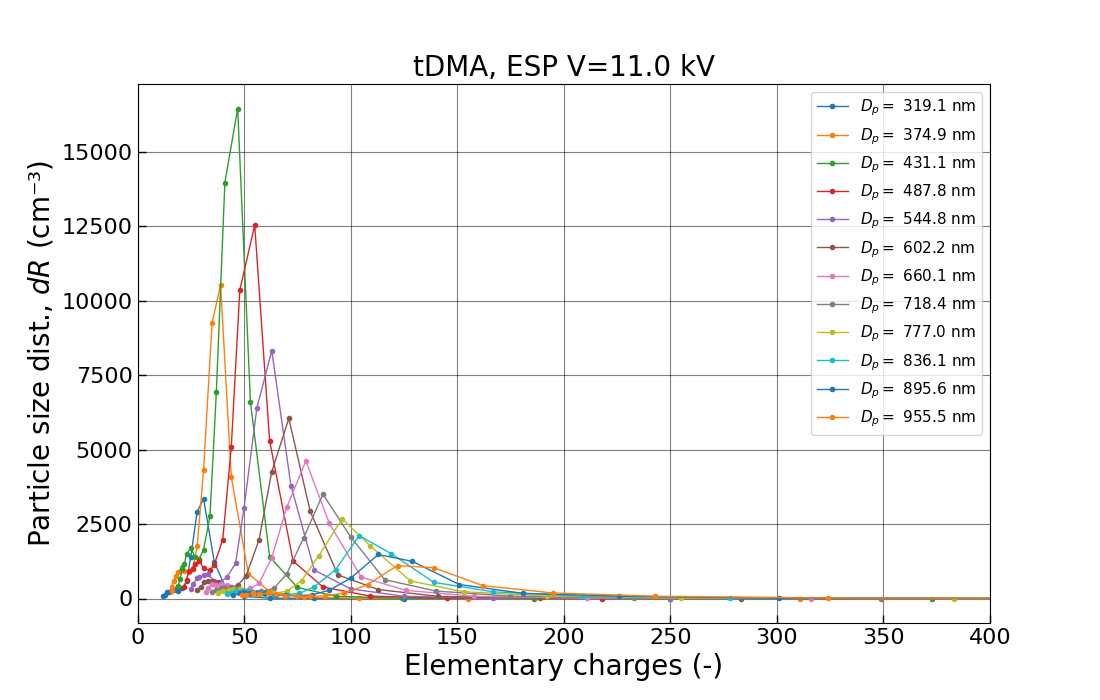

In [9]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])
Dps = np.unique(measurements_data_avg['Dp'].values.copy())

for espV in ESPV:
    DMA_APS_support.Plot_ESPV(espV, Dps, measurements_data_avg,
              line=True,
              row='z1_raw',
              column="R",
              spline=False,
              D_legend=True,
              LogYscale=False,
              export=False,
              skip=5,
              Dmax=1,
              sort_col="Dp",
              xmax = 400,
              prefix="OPS_Raw_TwoStDeconv_")

In [10]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'].values.copy())

measurements_data_avg["R1p"] = 0.
measurements_data_avg["N_deconv"] = 0.
measurements_data_avg["f1"] = 0.
measurements_data_avg["z1"] = 0
measurements_data_avg["R_conv"] = 0.
measurements_data_avg["R_conv_error"] = 0.

alpha = 5
z_cutoff = 300

for espV in tqdm(ESPV):
    data = measurements_data_avg[measurements_data_avg["ESP_V (kV)"] == espV].copy() 
    Dps = np.unique(data['Dp'].values.copy())
    for i in range(len(Dps)):
        #print('Analyzing: ',i+1,'/',len(Dps))
        data2 = data[data["Dp"] == Dps[i]].copy() 
        Voltage_vec = data2['Voltage'].values.copy()
        
        n_charges = 10
        R1p = data2.R.values.copy()
        R1p[R1p<1] = 1
        R1p = R1p - np.min(R1p)
        
        if (np.max(R1p) < 2):
            N_deconv = R1p * 0.
            f1 = R1p * 0.
        else:
            z1_min =  np.min(data2["z1_raw"][data2["R"]>1])
            z1_min =  np.max([1,int(z1_min*0.8)])
            z1 = z1_min-1 + np.arange(1,len(Voltage_vec)*n_charges+1,n_charges)
            title = "ESP_V "+str(espV)+" kV, Dp: "+str(Dps[i])+" µm"
            N_deconv,R_conv,R_conv_error = DMA_APS_support.Deconvolute_singleDMA_charges(dma,
                                                  z1,
                                                  R1p,
                                                  data2.Dp.values * 1e-06,
                                                  Voltage_vec,
                                                  check=False,
                                                  with_z_new=False,
                                                  cubic_spline=True,
                                                  z_max=np.max(z1),
                                                  n_z=400,
                                                  alpha=alpha,
                                                  title=title)
            f1 = DMA_APS_support.Get_charge_fraction(z1, N_deconv, zmax=z_cutoff)
        
        measurements_data_avg = DMA_APS_support.Set_column_ESPdata(measurements_data_avg,
                                               data2.index.values,
                                               R1p,"R1p")
        measurements_data_avg = DMA_APS_support.Set_column_ESPdata(measurements_data_avg,
                                               data2.index.values,
                                               z1,"z1")
        measurements_data_avg = DMA_APS_support.Set_column_ESPdata(measurements_data_avg,
                                               data2.index.values,
                                               N_deconv,"N_deconv")
        measurements_data_avg = DMA_APS_support.Set_column_ESPdata(measurements_data_avg,
                                               data2.index.values,
                                               f1,"f1")
        measurements_data_avg = DMA_APS_support.Set_column_ESPdata(measurements_data_avg,
                                               data2.index.values,
                                               R_conv,"R_conv")
        measurements_data_avg["N_deconv"][measurements_data_avg["N_deconv"] < 0] = 0
        del R1p,N_deconv,data2
    del data

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/jose/Desktop/GitHub/Bidimensional_DMA_APS_inversion/src/DMA_APS_support.py:254: RuntimeWarning: divide by zero encountered in divide
  R_conv_error = np.sqrt(np.power(R-R_conv,2))/R
/home/jose/Desktop/GitHub/Bidimensional_DMA_APS_inversion/src/DMA_APS_support.py:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c_name].iloc[i] = data[k]
/tmp/ipykernel_203607/1942770179.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurements_data_avg["N_deconv"][measurements_data_avg["N_deconv"] < 0] = 0
100%|█████████████████████████████

In [11]:

#measurements_data_avg

<IPython.core.display.Javascript object>


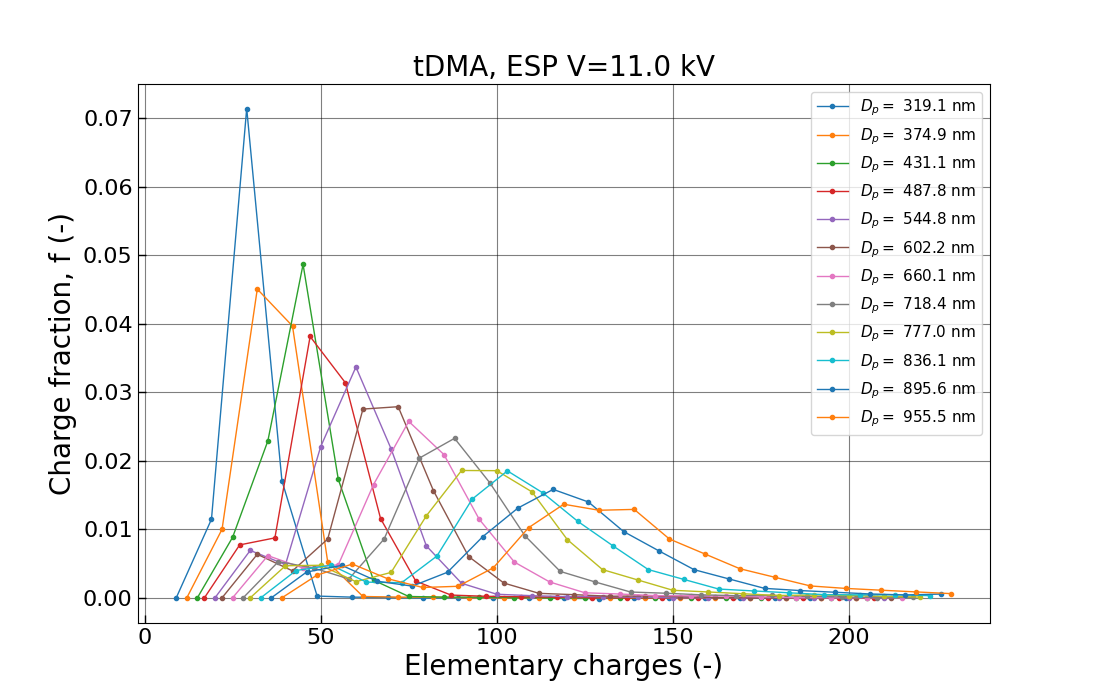

In [12]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'].values.copy())
Dps = np.unique(measurements_data_avg['Dp'].values.copy())

for espV in ESPV:
    DMA_APS_support.Plot_ESPV(espV,
                              Dps,
                              measurements_data_avg,
                              line=True,
                              row='z1',
                              column="f1",
                              spline=False,
                              D_legend=True,
                              LogYscale=False,
                              export=False,
                              skip=5,
                              Dmax=1,
                              sort_col="Dp",
                              prefix="APS_Deconv_")

In [13]:
measurements_data_avg.to_csv('APS_DMA_deconvoluted.dat', index=False, sep=',')  

## Comparison of inversion approaches

To ensure that the inverted result is reliable, we here compare it with the 2 aforementioned methods. This includes the so called "raw inversion" where the DMA transfer functions are neglected and a "2-step deconvolution" which is a deconvolution doing some assumptions to simplify the problem at the cost of lossing accuracy.

<IPython.core.display.Javascript object>


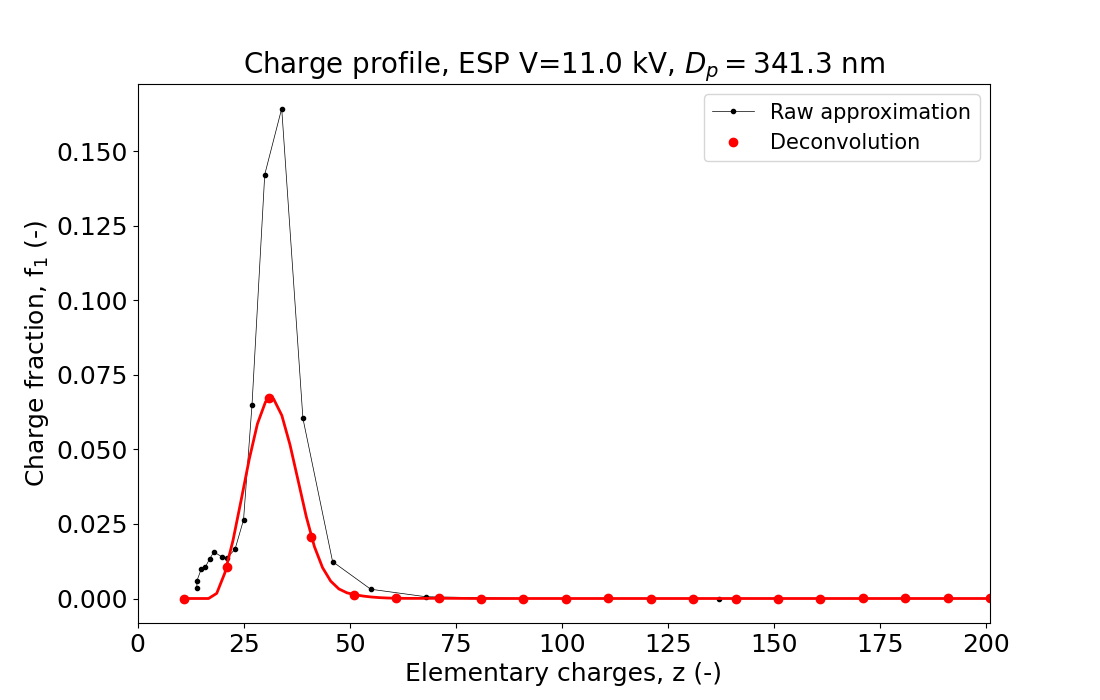

In [14]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])
espV = ESPV[-1]

data = measurements_data_avg[measurements_data_avg["ESP_V (kV)"] == espV].copy()

for i in [2]:#range(len(Dps)):
    data2 = data[data["Dp"] == Dps[i]].copy()
    DMA_APS_support.Plot_profiles(data2,
                                  espV,
                                  Dps[i]*1e-06,
                                  export=False,
                                  xmax=np.max(data2["z1"]))

## Contour plot

<IPython.core.display.Javascript object>


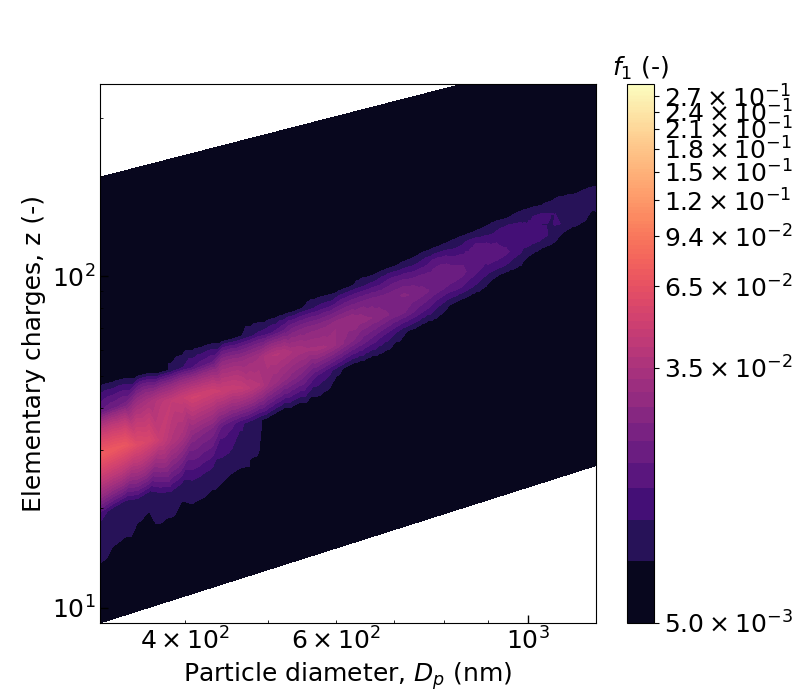

In [15]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])

for espV in ESPV:
    data = measurements_data_avg[measurements_data_avg["ESP_V (kV)"] == espV].copy()
    DMA_APS_support.Show_countour(data,
                     "2d-deconvoluted ESP V="+str(espV)+" kV",
                     espV,
                     z = "z1",
                     column = "f1",
                     cmap = 'magma',
                     size_x = 8,
                     size_y = 7,
                     normalized=False,
                     reshape_DZ=False,
                     logscale=True,
                     logxscale=True,
                     logyscale=True,
                     zmax=380,
                     dmax=1200,
                     export=False)